In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFECV
import time
%matplotlib inline

In [170]:
data = pd.read_csv('loans_2007.csv')
data.head()

c:\users\danger fellner\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [171]:
for i in data.columns:
    print(i)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
last_credit_pull_d
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
chargeoff_within_12_mths
delinq_amnt
pub_rec_bankruptcies
tax_liens


In [172]:
droppable_columns = ['id','member_id','funded_amnt','funded_amnt_inv','grade','sub_grade','emp_title','issue_d','zip_code','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt']
data = data.drop(droppable_columns,axis=1)
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths',
       'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [173]:
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
data = data.replace({'Fully Paid':1 , 'Charged Off' : 0})

In [174]:
drop_columns = []
for i in data.columns:
    if len(data[i].value_counts()) == 1:
        drop_columns.append(i)
data = data.drop(drop_columns,axis=1)
print(drop_columns)
print(data.columns)
print(len(data.columns))

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')
23


In [175]:
null_counts =  data.isnull().sum()
print(null_counts[null_counts > 0])

emp_length              1036
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64


In [176]:
data = data.drop(['pub_rec_bankruptcies'],axis=1)
data = data.dropna()
print(data.dtypes.value_counts())

object     11
float64    10
int64       1
dtype: int64


In [177]:
object_columns_df = data.select_dtypes(include=['object'])
object_columns_df.head()

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016
1,60 months,15.27%,< 1 year,RENT,Source Verified,car,bike,GA,Apr-1999,9.4%,Sep-2013
2,36 months,15.96%,10+ years,RENT,Not Verified,small_business,real estate business,IL,Nov-2001,98.5%,Jun-2016
3,36 months,13.49%,10+ years,RENT,Source Verified,other,personel,CA,Feb-1996,21%,Apr-2016
5,36 months,7.90%,3 years,RENT,Source Verified,wedding,My wedding loan I promise to pay back,AZ,Nov-2004,28.3%,Jan-2016


In [178]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']
for i in cols:
    print(data[i].value_counts())
    print('\n ----------- \n')

RENT        18112
MORTGAGE    16686
OWN          2778
OTHER          96
NONE            3
Name: home_ownership, dtype: int64

 ----------- 

Not Verified       16281
Verified           11856
Source Verified     9538
Name: verification_status, dtype: int64

 ----------- 

10+ years    8545
< 1 year     4513
2 years      4303
3 years      4022
4 years      3353
5 years      3202
1 year       3176
6 years      2177
7 years      1714
8 years      1442
9 years      1228
Name: emp_length, dtype: int64

 ----------- 

 36 months    28234
 60 months     9441
Name: term, dtype: int64

 ----------- 

CA    6776
NY    3614
FL    2704
TX    2613
NJ    1776
IL    1447
PA    1442
VA    1347
GA    1323
MA    1272
OH    1149
MD    1008
AZ     807
WA     788
CO     748
NC     729
CT     711
MI     678
MO     648
MN     581
NV     466
SC     454
WI     427
OR     422
AL     420
LA     420
KY     311
OK     285
UT     249
KS     249
AR     229
DC     209
RI     194
NM     180
WV     164
HI     162
NH    

In [179]:
print(data['title'].value_counts())
print('\n ------- \n')
print(data['purpose'].value_counts())

Debt Consolidation                     2068
Debt Consolidation Loan                1599
Personal Loan                           624
Consolidation                           488
debt consolidation                      466
                                       ... 
Legal fees for divorce                    1
Auto Sep11                                1
Carl Hennessy Home Improvement Loan       1
suzuki sv650                              1
Jordan                                    1
Name: title, Length: 18881, dtype: int64

 ------- 

debt_consolidation    17751
credit_card            4911
other                  3711
home_improvement       2808
major_purchase         2083
small_business         1719
car                    1459
wedding                 916
medical                 655
moving                  552
house                   356
vacation                348
educational             312
renewable_energy         94
Name: purpose, dtype: int64


In [180]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

data = data.drop(['last_credit_pull_d','addr_state','title','earliest_cr_line'],axis=1)
data['int_rate'] = data['int_rate'].str.replace('%','')
data['revol_util'] = data['revol_util'].str.replace('%','')
data['int_rate'] = data['int_rate'].astype(float)
data['revol_util'] = data['revol_util'].astype(float)
data[['emp_length']] = data[['emp_length']].replace(mapping_dict)

In [181]:
dummy_df = pd.get_dummies(data[['home_ownership','verification_status','purpose','term']])
data = pd.concat([data,dummy_df],axis=1)
data = data.drop(['home_ownership','verification_status','purpose','term'],axis=1)

In [182]:
def check(o,t,predictions):
    return sum((predictions == o) & (data['loan_status'] == t))
def check_all(predictions):
    tn = check(0,0,predictions)
    tp = check(1,1,predictions)
    fn = check(0,1,predictions)
    fp = check(1,0,predictions)
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    print("true negatives: {}\ntrue positives: {}\nfalse negatives: {}\nfalse positives: {}".format(tn,tp,fn,fp))
    print("false positive rate: {}\ntrue positive rate: {}".format(fpr,tpr))

In [183]:
features = data.drop(['loan_status'],axis=1)
features = features.astype(np.float32)
target = data['loan_status']
scaler = preprocessing.StandardScaler().fit(features)
##target doesn't need to be scaled since it's already either 0 or 1
scaled= scaler.transform(features)

In [184]:
def timer(func):
    def wrapper(*args, **kwargs):
        t_start = time.time()

        result = func(*args, **kwargs)

        t_total = round(time.time() - t_start,2)
        print('\n{} took {}s'.format(func.__name__, t_total))
    
        return result
    return wrapper
@timer
def model_test(model):
    predictions = cross_val_predict(model,scaled,target,cv=3)
    predictions = pd.Series(predictions)
    check_all(predictions)

In [185]:
model_test(LogisticRegression(class_weight='balanced'))

true negatives: 1947
true positives: 19131
false negatives: 11381
false positives: 3118
false positive rate: 0.6155972359328726
true positive rate: 0.6269992134242265

model_test took 0.63s


In [199]:
rf = RFECV(LogisticRegression(class_weight='balanced'))
model_test(rf)

true negatives: 2026
true positives: 18883
false negatives: 11629
false positives: 3039
false positive rate: 0.6
true positive rate: 0.6188712637650761

model_test took 56.75s


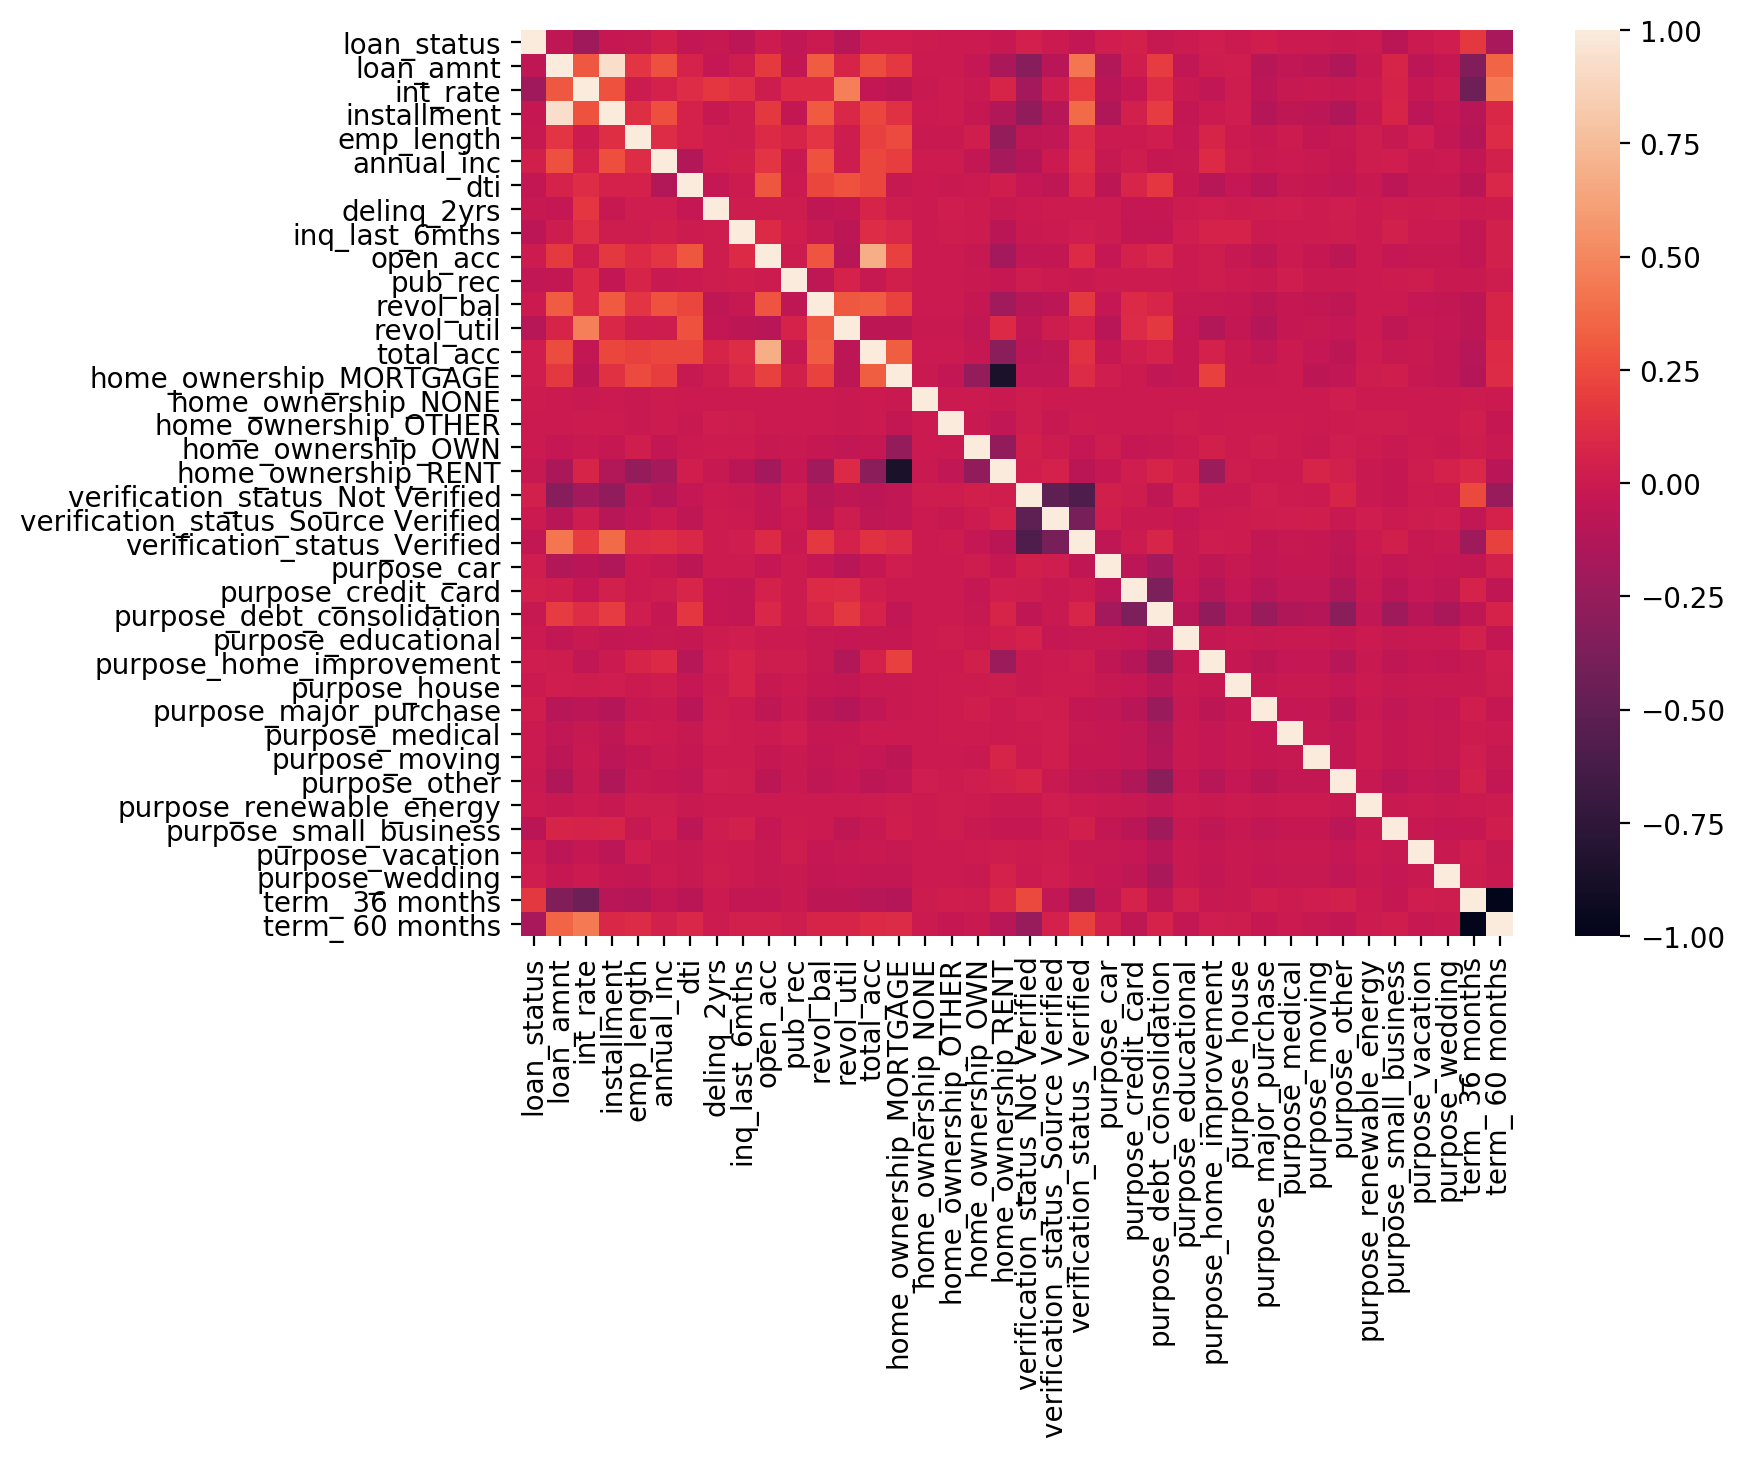

In [197]:
plt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')
loan_status_first = pd.concat([data[['loan_status']],data.drop(['loan_status'],axis=1)],axis=1)
sns.heatmap(loan_status_first.corr(),xticklabels=True,yticklabels=True)
plt.show()

In [188]:
data.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')